In [1]:
#assert python version >=3,5
import sys
assert sys.version_info >= (3,5)

from abc import ABC, abstractclassmethod
from collections import deque
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random
from time import sleep
from typing import List

import gymnasium as gym
assert gym.__version__ >= '0.27.1'
from tqdm import tqdm

%matplotlib inline

### Некоторое описание среды

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect 
attempts to pick-up/drop-off passenger and for each step where another reward is not received.

#### Action Space

The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

<ul>
<li>0: Move south (down)</li>
<li>1: Move north (up)</li>
<li>2: Move east (right)</li>
<li>3: Move west (left)</li>
<li>4: Pickup passenger</li>
<li>5: Drop off passenger</li>
</ul>    

#### Observation Space

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
Destination on the map are represented with the first letter of the color.
Passenger locations:
<ul>
<li>0: Red</li>
<li>1: Green</li>
<li>2: Yellow</li>
<li>3: Blue</li>
<li>4: In taxi</li>
</ul>
Destinations:
<ul>
<li>0: Red</li>
<li>1: Green</li>
<li>2: Yellow</li>
<li>3: Blue</li>
</ul>

#### Rewards
<ul>
<li>-1 per step unless other reward is triggered.</li>
<li>+20 delivering passenger.</li>
<li>-10 executing “pickup” and “drop-off” actions illegally.</li>
</ul>

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.

#### Episode End
The episode ends if the following happens:
Termination: 1. The taxi drops off the passenger.
Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.


### Псевдо-Код QLearning

![Q-Learning](The-Q-Learning-Algorithm-6.png)

In [2]:
class Agent():
    """
    Базовый класс Агент для различных алгоритмов rl


    Attributes
    ----------
    _n_actions : int
        число возможных действий, который агент может выполнить 
    _actions : np.ndarray
        массив возможных действий
    _n_states : int
        число возможных состояний, которые агент может наблюдать 
    _policy : np.ndarray
        Q матрица политики агента (состояния на действия)
    _epsilon : float
        текущий параметр Эпсилон для определения жадной политики (вероятность наблюдения(Exploration))
    _start_epsilon : float
        изначально заданный параметр Эпсилон для определения жадной политики (вероятность наблюдения(Exploration))


    Methods
    -------
    act(state:int) -> int
        выполнить действие из переданного состояния согласно реализуемому алгоритму
    
    update_policy(episode_num: int) -> None
        выполнить обновление политики после ранее сделанного шага
    
    _is_exploration() -> bool
        случайным образом решает выполнить ли сейчас Exploration либо Exploatation среды
    """

    
    def __init__(self, n_actions:int, n_states:int, epsilon: float):
        assert(n_actions > 1)
        assert(n_states > 1)
        assert(epsilon > 0 and epsilon <= 1)
        self._n_actions = n_actions
        self._actions = np.arange(0, n_actions)
        self._n_states = n_states
        self._policy = np.zeros((n_states, n_actions), dtype=float)
        self._start_epsilon = epsilon
        self._epsilon = epsilon
    
    
    def act(self, state:int) -> int:
        assert(state >= 0 and state < self._n_states)
    
        
    def update_policy(self, episode_num: int) -> None:
        assert(episode_num > 0)
        self._epsilon = self._start_epsilon / episode_num
        
        
    def _is_exploration(self) -> bool:
        return np.random.uniform(0,1) < self._epsilon
        

In [6]:
class QLearningAgent(Agent):
    """
    Класс Агента для алгоритма QLearning


    Attributes
    ----------
    _alpha : float
        learning rate для процесса обучения 
    _gamma : float
        коэффициент дисконтирования
    _current_state : int
        номер текущего состояния из списка obseration_space
    _current_action : int
        номер выполненного действия агентом


    Methods
    -------
    act(state:int) -> int
        выполнить действие из переданного состояния согласно реализуемому алгоритму
    
    update_policy(episode_num: int) -> None
        выполнить обновление политики после ранее сделанного шага
    
    """
    
    def __init__(self, n_actions:int, n_states:int, epsilon: float, alpha:float=0.2, gamma:float=0.995):
        assert(alpha > 0 and alpha < 1)
        assert(gamma >= 0.9 and gamma < 1)
        
        super().__init__(n_actions, n_states, epsilon)
        self._alpha = alpha
        self._gamma = gamma
        self._current_state = None
        self._current_action = None
    
    
    def act(self, state:int) -> int:
        """выбор действия из переданного состояния

        Parameters
        ----------
        state : int
            Текущее состояние среды в котором нужно сделать действие

        Returns
        ------
            номер действия
        
        """
        super().act(state)
        
        if self._is_exploration():
            action =  np.random.choice(self._actions)
        else:
            action = np.argmax(self._policy[state, :])
        
        self._current_action = action
        self._current_state = state
        
        return action
        
    
    def update_policy(self, new_state:int, reward:float, episode_num: int) -> None:
        """обновление политики после того как среда выполнит действие

        Parameters
        ----------
        new_state : int
            Новой состояние среды в которое перешли после действия
        reward : int
            Полученна при этом награда
        episode_num : int
            Текущий номер эпизода

        Returns
        ------
        """

        assert(new_state >= 0 and new_state < self._n_states)
       
        super().update_policy(episode_num)
        #вычисление temporal difference
        td = self._gamma * np.max(self._policy[new_state, :]) - self._policy[self._current_state, self._current_action]
        #обновление ячейки политики
        self._policy[self._current_state, self._current_action] = self._policy[self._current_state, self._current_action] + self._alpha * (td + reward)
            

In [7]:
class Game:
    """
    Класс Игра, который связывает среду и агента и выполняет прогоны эпизодов


    Attributes
    ----------
    _env : gym.Env
        игровая среда
    _agent : Agent
        наш агент
    _n_episodes : int
        сколько эпизодов игры выполнять 
    _cum_rewards : list
        список с суммарными наградами за Н последних эпизодов
    _avg_rewards : list
        список со средними наградами за Н последних эпизодов
    __STAT_BUFF_LEN__ : int
        константа, за сколько эпизодов собирать статистику

    Methods
    -------
    play() -> None
        выполнить розыгрыш заданного числа эпизодов и собрать статистику
    
    visualize_epizode(seed: int, many_frames : bool =False) -> None
        позволяет визуализировать как играет агент после обучения
    """
    
    __STAT_BUFF_LEN__ = 100
    
    def __init__(self, env:gym.Env, agent: Agent, n_episodes:int):
        assert(env is not None)
        assert(agent is not None)
        assert(n_episodes > 0)
        
        self._env = env
        self._agent = agent
        self._n_episodes = n_episodes
        self._cum_rewards = []
        self._avg_rewards = []

        
    def play(self):
        """проигрыш эпизодов, фактически обучение агента

        Parameters
        ----------

        Returns
        ------
        """
        #буфер-накопитель для статистик
        rewards = deque(maxlen = self.__STAT_BUFF_LEN__)
        #цикл по эпизодам
        for episode in tqdm(range(1, self._n_episodes + 1)):
            state, _ = self._env.reset()
            episode_reward = 0.0
            terminated = False
            truncated = False
            #проигрыш одного эпизода
            while not terminated and not truncated:
                action = self._agent.act(state)
                next_state, reward, terminated, truncated, info = self._env.step(action)
                self._agent.update_policy(next_state, reward, episode)
                state = next_state
                episode_reward += reward
            rewards.append(episode_reward)
            if episode >= self.__STAT_BUFF_LEN__:
                self._cum_rewards.append(np.sum(rewards))
                self._avg_rewards.append(np.mean(rewards))
                
                
    def visualize_epizode(self, seed:int = 132, many_frames:bool = False):
        """Визуализация эпизода

        Parameters
        ----------
        seed : int
            Среда генерирует разные начальные положения объектов при разных seed
        many_frames : bool
            Если параметр установлен в Истину, будет отображена последовательность кадров игры, а иначе все действия
            будут проходить динамически в одном кадре

        Returns
        ------
        """
        state, info = self._env.reset(seed=seed)
        for i in range(self._env.spec.max_episode_steps):
            plt.imshow(self._env.render())
            display.display(plt.gcf())    
            if not many_frames:
                display.clear_output(wait=True)
            action = self._agent.act(state)
            state, reward, terminated, truncated, info = self._env.step(action)
            if terminated or truncated:
                break
            sleep(1)                

            
    def cum_rewards(self) -> List[float]:
        """Возвращаем буфер кумулятивных наград

        Parameters
        ----------

        Returns
        ------
            List[float] - буфер кумулятивных наград
        """
        return self._cum_rewards.copy()
    
    
    def avg_rewards(self) -> List[float]:
        """Возвращаем буфер средних наград

        Parameters
        ----------

        Returns
        ------
            List[float] - буфер средних наград
        """
        return self._avg_rewards.copy()

### Выполнение игры и визуализации

In [8]:
#создаем среду
env = gym.make("Taxi-v3",render_mode="rgb_array")
#агент
agent = QLearningAgent(n_actions=env.action_space.n, n_states=env.observation_space.n, epsilon=1)
#создаем и играем 
game = Game(env, agent, n_episodes=2500)
game.play()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1599.90it/s]


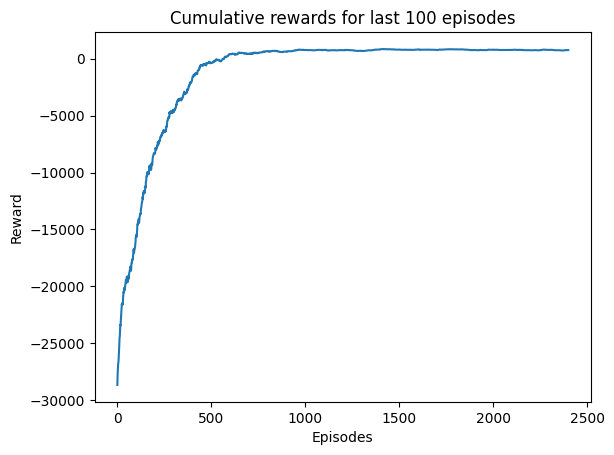

In [9]:
plt.plot(game.cum_rewards())
plt.xlabel('Episodes', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.title('Cumulative rewards for last 100 episodes', fontsize=12)
plt.show()

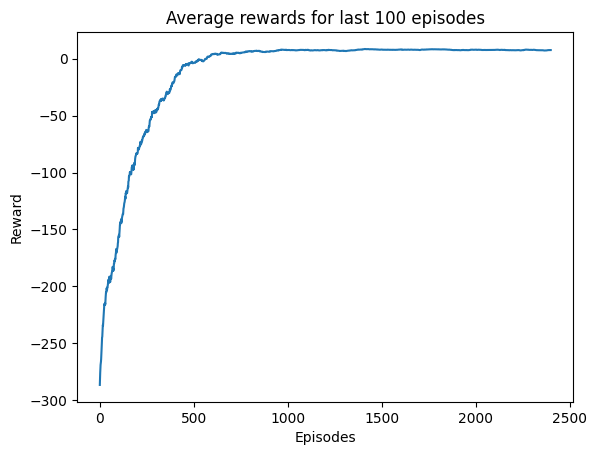

In [10]:
plt.plot(game.avg_rewards())
plt.xlabel('Episodes', fontsize=10,)
plt.ylabel('Reward', fontsize=10)
plt.title('Average rewards for last 100 episodes', fontsize=12)
plt.show()

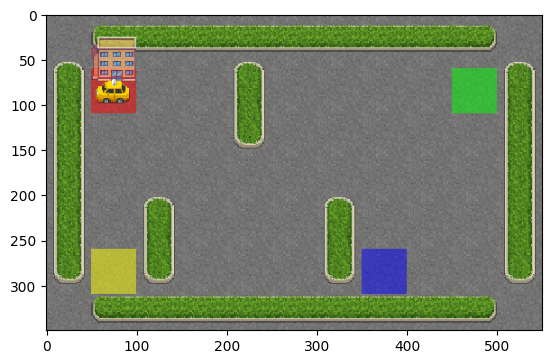

In [11]:
#Визуализация игры Агента после обучения
game.visualize_epizode(seed=12)